In [5]:
!pip install torchinfo

### Import Libraries

In [6]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

### Configuration

In [ ]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [ ]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [ ]:
data_dir = "/kaggle/input/brain-tumor-mri-images-44c"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Meningioma T1C+, Count: 369
Class: Meningioma T1, Count: 272
Class: _NORMAL T2, Count: 271
Class: _NORMAL T1, Count: 251
Class: Meningioma T2, Count: 233
Class: Astrocitoma T1C+, Count: 233
Class: Neurocitoma T1C+, Count: 223
Class: Schwannoma T1C+, Count: 194
Class: Astrocitoma T1, Count: 176
Class: Astrocitoma T2, Count: 171
Class: Schwannoma T1, Count: 148
Class: Neurocitoma T1, Count: 130
Class: Schwannoma T2, Count: 123
Class: Carcinoma T1C+, Count: 112
Class: Papiloma T1C+, Count: 108
Class: Neurocitoma T2, Count: 104
Class: Glioblastoma T1C+, Count: 94
Class: Oligodendroglioma T1, Count: 86
Class: Tuberculoma T1C+, Count: 84
Class: Carcinoma T2, Count: 73
Class: Oligodendroglioma T1C+, Count: 72
Class: Meduloblastoma T1C+, Count: 67
Class: Oligodendroglioma T2, Count: 66
Class: Carcinoma T1, Count: 66
Class: Papiloma T1, Count: 66
Class: Papiloma T2, Count: 63
Class: Ependimoma T2, Count: 57
Class: Glioblastoma T1, Count: 55
Class: Glioblastoma T2, Count: 55
Class: Ependi

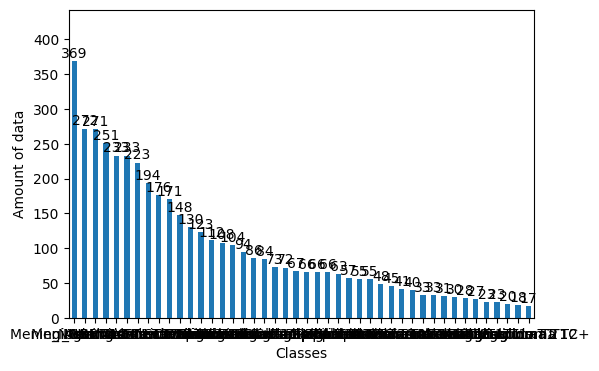

In [ ]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

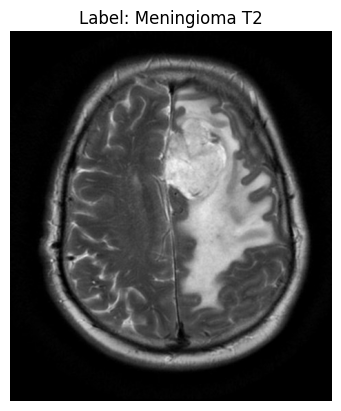

In [ ]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [ ]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [ ]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  3135
Validation Data:  672
Test Data:  672
-------------------------------------------
Total amounts of data in the dataset:  4479


In [ ]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                     Count
----------------------  -------
Meningioma T1C+             258
Meningioma T1               190
_NORMAL T2                  190
_NORMAL T1                  176
Meningioma T2               163
Astrocitoma T1C+            163
Neurocitoma T1C+            156
Schwannoma T1C+             136
Astrocitoma T1              123
Astrocitoma T2              120
Schwannoma T1               104
Neurocitoma T1               91
Schwannoma T2                86
Carcinoma T1C+               78
Papiloma T1C+                76
Neurocitoma T2               73
Glioblastoma T1C+            66
Oligodendroglioma T1         60
Tuberculoma T1C+             59
Carcinoma T2                 51
Oligodendroglioma T1C+       50
Meduloblastoma T1C+          47
Oligodendroglioma T2         46
Papiloma T1                  46
Carcinoma T1                 46
Papiloma T2                  44
Ependimoma T2                40
Glioblastoma T2              38
Glioblastoma T1           

### Device Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [ ]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {
           'Meningioma T1C+': 0,
        'Meningioma T1': 1,
        '_NORMAL T2': 2,
        '_NORMAL T1': 3,
        'Meningioma T2': 4,
        'Astrocitoma T1C+': 5,
        'Neurocitoma T1C+': 6,
        'Schwannoma T1C+': 7,
        'Astrocitoma T1': 8,
        'Astrocitoma T2': 9,
        'Schwannoma T1': 10,
        'Neurocitoma T1': 11,
        'Schwannoma T2': 12,
        'Carcinoma T1C+': 13,
        'Papiloma T1C+': 14,
        'Neurocitoma T2': 15,
        'Glioblastoma T1C+': 16,
        'Oligodendroglioma T1': 17,
        'Tuberculoma T1C+': 18,
        'Carcinoma T2': 19,
        'Oligodendroglioma T1C+': 20,
        'Meduloblastoma T1C+': 21,
        'Oligodendroglioma T2': 22,
        'Carcinoma T1': 23,
        'Papiloma T1': 24,
        'Papiloma T2': 25,
        'Ependimoma T2': 26,
        'Glioblastoma T1': 27,
        'Glioblastoma T2': 28,
        'Ependimoma T1C+': 29,
        'Ependimoma T1': 30,
        'Meduloblastoma T2': 31,
        'Germinoma T1C+': 32,
        'Germinoma T2': 33,
        'Tuberculoma T2': 34,
        'Granuloma T1C+': 35,
        'Granuloma T1': 36,
        'Tuberculoma T1': 37,
        'Germinoma T1': 38,
        'Meduloblastoma T1': 39,
        'Ganglioglioma T2': 40,
        'Ganglioglioma T1': 41,
        'Ganglioglioma T1C+': 42,
        'Granuloma T2': 43
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path)

        # Convert image to RGB if it's not already in RGB format
        image = image.convert("RGB")

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [ ]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [ ]:
total_class = 44
learning_rate = 0.0001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 44]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 